<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/RNN_For_1D_Colored_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Main Goals

1. What is the best RNN cell to predeict Colored noise?
2. What is the best hyperparameters configuration for each cell?
3. Is the `mse` the best loss function? Can we inplement the $\beta$ long term analyse? 
4. What about `deepAR`, `Arima`, `Prophet`, [`WaveNet`](https://homl.info/wavenet) and `Transformer`?
5. What about [`LSTMAutoencoder`](https://www.youtube.com/watch?v=6S2v7G-OupA)? 
6. 

# Some questions:

*  Is the `look_back` to long? Add inicial 1D convolutional layer?
*  

## Downloading data

In [ ]:
#Monting Google Drive
#https://medium.com/analyatics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
!kaggle datasets download -d luanorionbarana/synthetic-colored-noise
#Unziping data-set
!unzip "synthetic-colored-noise.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle
synthetic-colored-noise.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  synthetic-colored-noise.zip
replace /content/color.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# #Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content


# Librarys

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, LSTM, GRU, RNN,SimpleRNN
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
#from datetime import datetime # for put the time info in each plot          #https://stackoverflow.com/questions/415511/how-to-get-the-current-time-in-python
import time as time

## Ploting

In [2]:
df = pd.read_pickle('color_4series.plk')

Text(0, 0.5, 'Amplitude')

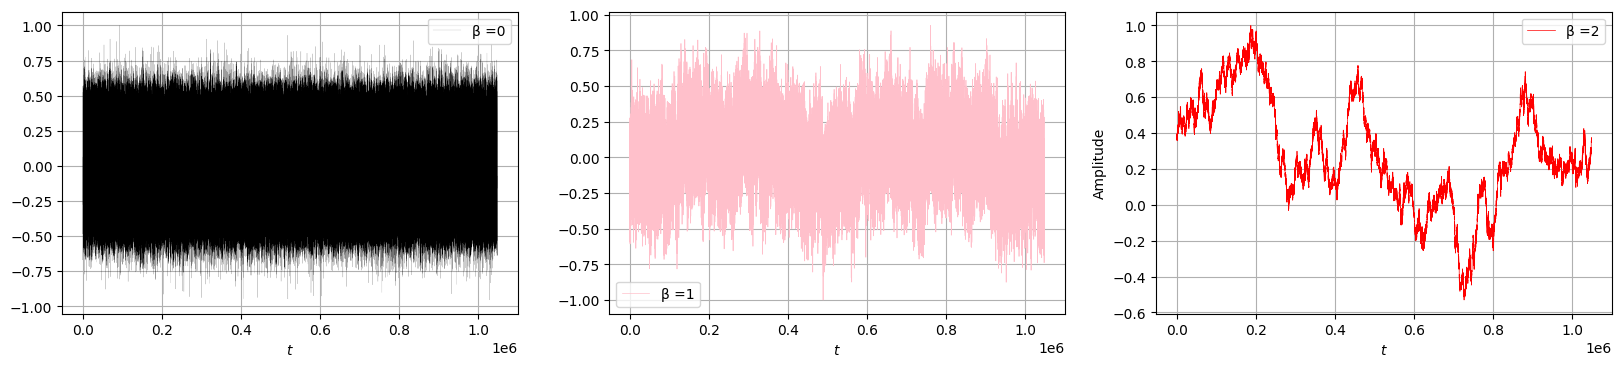

In [3]:
index = [0,4,9]
color = ['black','pink','red']
linewidth = [0.07,0.5,.5]
plt.figure(figsize=(20,4),dpi=100)
for i in range(len(index)):
  plt.subplot(1,3,i+1)
  plt.plot(df.Series[index[i]][:],label='β ='+str(df.beta[index[i]]),color=color[i],linewidth=linewidth[i])
  plt.grid()
  plt.legend()
  plt.xlabel('$t$')
plt.ylabel('Amplitude')
  #plt.title(color[i]+ ' noise')
#plt.suptitle('Colored Noise')


# Pre-processing

In [4]:
#serie_index = 0  #white Noise
#serie_index = 40 #pink noise
serie_index =  9#red Noise

min_size , max_size = 0 , len(df.Series[0])

dataframe = pd.DataFrame({"Serie":df['Series'][serie_index][min_size:max_size]})
dataset = dataframe.values.astype('float32')
beta = str(df['beta'][serie_index])

In [5]:
# definindo as amostras de treinamento e teste segundo o hold-out.
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
# conversão da série temporal em uma matriz de atributos para regressão
def create_dataset(dataset, look_back=10):
	'''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the look_back is equal to 3 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3]
  dataX[1] = [1,2,3] ; dataY[1] = [4]
  dataX[2] = [2,3,4] ; dataY[2] = [5]
  dataX[3] = [3,4,5] ; dataY[3] = [6]
	'''
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
look_back = 2**10

trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test,  look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX,(trainX.shape[0],1, trainX.shape[1]))
testX =  np.reshape(testX, (testX.shape[0],1, testX.shape[1]))
#valX =   np.reshape(valX,  (valX.shape[0],  1, valX.shape[1]))

# Model

In [8]:
#Setting Random seeds🌱
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(3)

In [9]:
#Paramenters 
epochs = 150
batch_size = len(trainX)#256#look_back*10
#batch_size = len(trainX)# 
n_1 = 4#10#int(look_back*100)
n_2 = 10#int(look_back*100)
n_3 = 10 #int(look_back*1e-1)
n_4 = 4#10#int(look_back*1e-1)

In [10]:
star_RNN = time.time()
model_RNN = Sequential()
model_RNN.add(SimpleRNN(n_1,input_shape=(1,look_back)))
#model_RNN.add(SimpleRNN(n_1, return_sequences=True,input_shape=(1,look_back)))
#model_RNN.add(SimpleRNN(n_2, return_sequences=True))
#model_RNN.add(SimpleRNN(n_3, return_sequences=True))
#model_RNN.add(SimpleRNN(n_4))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_RNN = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)
#model_RNN.save('model_RNN')
time_RNN = time.time()

Epoch 1/150
1/1 [==============================] - 6s 6s/step - loss: 0.2780 - mse: 0.2780 - val_loss: 0.2632 - val_mse: 0.2632
Epoch 2/150
1/1 [==============================] - 4s 4s/step - loss: 0.4028 - mse: 0.4028 - val_loss: 0.2071 - val_mse: 0.2071
Epoch 3/150
1/1 [==============================] - 4s 4s/step - loss: 0.3076 - mse: 0.3076 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 4/150
1/1 [==============================] - 4s 4s/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0521 - val_mse: 0.0521
Epoch 5/150
1/1 [==============================] - 4s 4s/step - loss: 0.0634 - mse: 0.0634 - val_loss: 0.1231 - val_mse: 0.1231
Epoch 6/150
1/1 [==============================] - 3s 3s/step - loss: 0.1766 - mse: 0.1766 - val_loss: 0.1134 - val_mse: 0.1134
Epoch 7/150
1/1 [==============================] - 5s 5s/step - loss: 0.1634 - mse: 0.1634 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 8/150
1/1 [==============================] - 5s 5s/step - loss: 0.0821 - mse: 0.0821 - val_loss: 0

In [11]:
star_LSTM = time.time()
model_LSTM = Sequential()
model_LSTM.add(LSTM(n_1, input_shape=(1,look_back)))
#model_LSTM.add(LSTM(n_1, return_sequences=True,input_shape=(1,look_back)))
#model_LSTM.add(LSTM(n_2, return_sequences=True))
#model_LSTM.add(LSTM(n_3, return_sequences=True))
#model_LSTM.add(LSTM(n_4))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_LSTM = model_LSTM.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)
time_LSTM = time.time()
#model_LSTM.save('model_LSTM')
#!zip -r /content/drive/MyDrive/Kaggle/model_LSTM.zip /content/model_LSTM/

Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 0.5530 - mse: 0.5530 - val_loss: 0.1150 - val_mse: 0.1150
Epoch 2/150
1/1 [==============================] - 3s 3s/step - loss: 0.1737 - mse: 0.1737 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 3/150
1/1 [==============================] - 3s 3s/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/150
1/1 [==============================] - 3s 3s/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 5/150
1/1 [==============================] - 3s 3s/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 6/150
1/1 [==============================] - 3s 3s/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 7/150
1/1 [==============================] - 3s 3s/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 8/150
1/1 [==============================] - 3s 3s/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0

In [12]:
star_GRU = time.time()
model_GRU = Sequential()
model_GRU.add(GRU(n_1, input_shape=(1,look_back)))
#model_GRU.add(GRU(n_1, return_sequences=True,input_shape=(1,look_back)))
#model_GRU.add(GRU(n_2, return_sequences=True))
#model_GRU.add(GRU(n_3, return_sequences=True))
#model_GRU.add(GRU(n_4))
model_GRU.add(Dense(1))
model_GRU.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_GRU = model_GRU.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)
time_GRU = time.time()
# model_GRU.save('model_GRU')
# !zip -r /content/drive/MyDrive/Kaggle/model_GRU.zip /content/model_GRU/

Epoch 1/150
1/1 [==============================] - 11s 11s/step - loss: 0.0796 - mse: 0.0796 - val_loss: 0.0461 - val_mse: 0.0461
Epoch 2/150
1/1 [==============================] - 5s 5s/step - loss: 0.0599 - mse: 0.0599 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 3/150
1/1 [==============================] - 4s 4s/step - loss: 0.0612 - mse: 0.0612 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 4/150
1/1 [==============================] - 3s 3s/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 5/150
1/1 [==============================] - 4s 4s/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 6/150
1/1 [==============================] - 3s 3s/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 7/150
1/1 [==============================] - 3s 3s/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 8/150
1/1 [==============================] - 3s 3s/step - loss: 0.0222 - mse: 0.0222 - val_loss:

In [13]:
#Alocationg all the models in vectors!

model = [model_RNN,model_LSTM,model_GRU]
history = [history_RNN,history_LSTM,history_GRU]
model_name = ['Simple RNN','LSTM','GRU']
color = ['C0','C1','C2']

#Allocating metrics
loss, mse, val_loss =[],[],[]
for i in range(len(model)):
  loss.append(history[i].history['loss'])
  mse.append(history[i].history['mse'])
  val_loss.append(history[i].history['val_loss'])

In [14]:
model[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 16464     
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 16,469
Trainable params: 16,469
Non-trainable params: 0
_________________________________________________________________


In [15]:
Time =[round((time_RNN - star_RNN)/60,5), round((time_LSTM - star_LSTM)/60,5), round((time_GRU - star_GRU)/60,5)]
for i in range (len(Time)):  print(model_name[i],Time[i],'minutus') if Time[i] < 100 else print(model_name[i],round(Time[i]/60,4),'hours')

Simple RNN 11.39113 minutus
LSTM 9.42246 minutus
GRU 8.9766 minutus


In [16]:
for i in range (len(model)): print(model_name[i]+'\n'+str(model[i].evaluate(testX, testY)),'\n')

16352/16352 [==============================] - 35s 2ms/step - loss: 0.0105 - mse: 0.0105
Simple RNN
[0.010549560189247131, 0.010549560189247131] 

16352/16352 [==============================] - 39s 2ms/step - loss: 0.1208 - mse: 0.1208
LSTM
[0.12075546383857727, 0.12075546383857727] 

16352/16352 [==============================] - 31s 2ms/step - loss: 0.0437 - mse: 0.0437
GRU
[0.043690409511327744, 0.043690409511327744] 



# Results

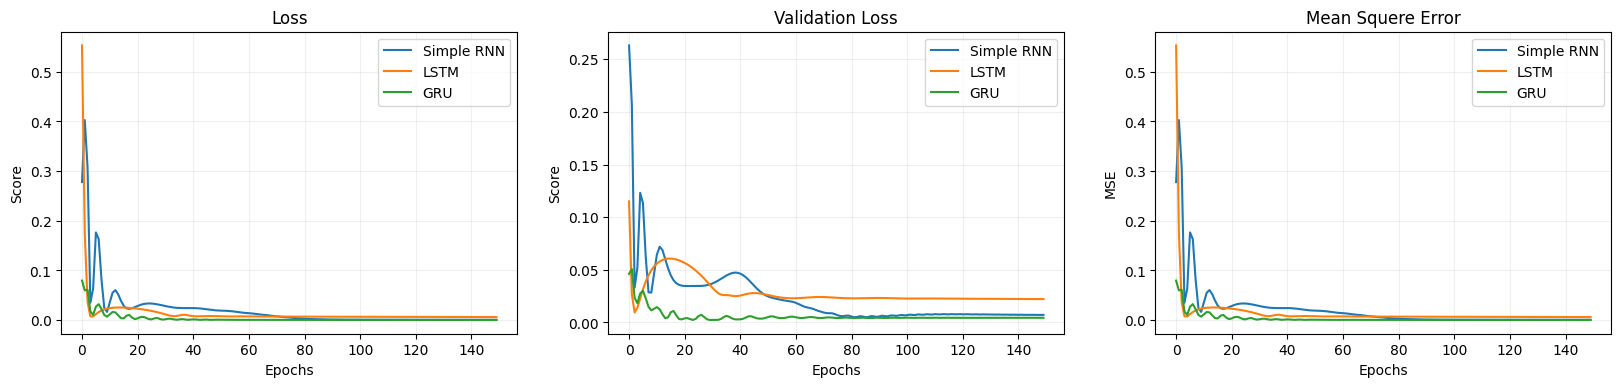

In [17]:
epochs = np.arange(0,len(loss[0]))
plt.figure(figsize=(20, 4),dpi=100)

plt.subplot(1,3,1)
for i in range(len(model)): plt.plot(epochs,loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Loss')
#plt.ylim(-0.01,0.2)
plt.grid(alpha=0.2)

plt.subplot(1,3,2)
for i in range(len(model)): plt.plot(epochs,val_loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Loss')
#plt.ylim(-0.01,0.13)
plt.grid(alpha=0.2)


plt.subplot(1,3,3)
for i in range(len(model)): plt.plot(epochs,mse[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title("Mean Squere Error")
#plt.ylim(-0.01,0.2)
plt.grid(alpha=0.2)

plt.show()

In [18]:
'''
Aqui iremos alocar a previsão do treinamento, to teste e de ambos em vetores. 
Para o caso dos valores de test eles precisam estar na posição em que o treinamento acaba para que possamos comparar no mesmo dataset
'''

# make predictions
trainPredict, testPredict, trainPredictPlot, testPredictPlot, model_data = [],[],[],[],[]

for i in range(len(model)):
  #Train
  trainPredict.append(model[i].predict(trainX))
  a = np.empty_like(dataset)
  a[:, :] = np.nan
  a[look_back:len(trainPredict[i])+look_back, :] = trainPredict[i]
  trainPredictPlot.append(a)
  #Teste
  testPredict.append(model[i].predict(testX))
  a = np.empty_like(dataset)
  a[:, :] = np.nan
  a[len(trainPredict[i])+(look_back*2)+1:len(dataset)-1, :] = testPredict[i]
  testPredictPlot.append(a)
  #All
  a =  np.empty_like(dataset) #creating a empyt vector
  a[look_back:len(trainPredict[i])+look_back, :] = trainPredict[i] #alocating the the traint data generatead by the model
  a[len(trainPredict[i])+(look_back*2)+1:len(dataset)-1, :] = testPredict[i] #alocating the the test data generatead by the model
  a = (np.reshape(a,(len(a))))
  a[:look_back] = np.nan
  #model_data = model_data[look_back:]
  # Killing divergences
  for i in range(len(a)):
      if a[i] > 1: a[i] = np.nan
      #if a[i] < 0.0001: a[i] = 0
  model_data.append(a)   
del a

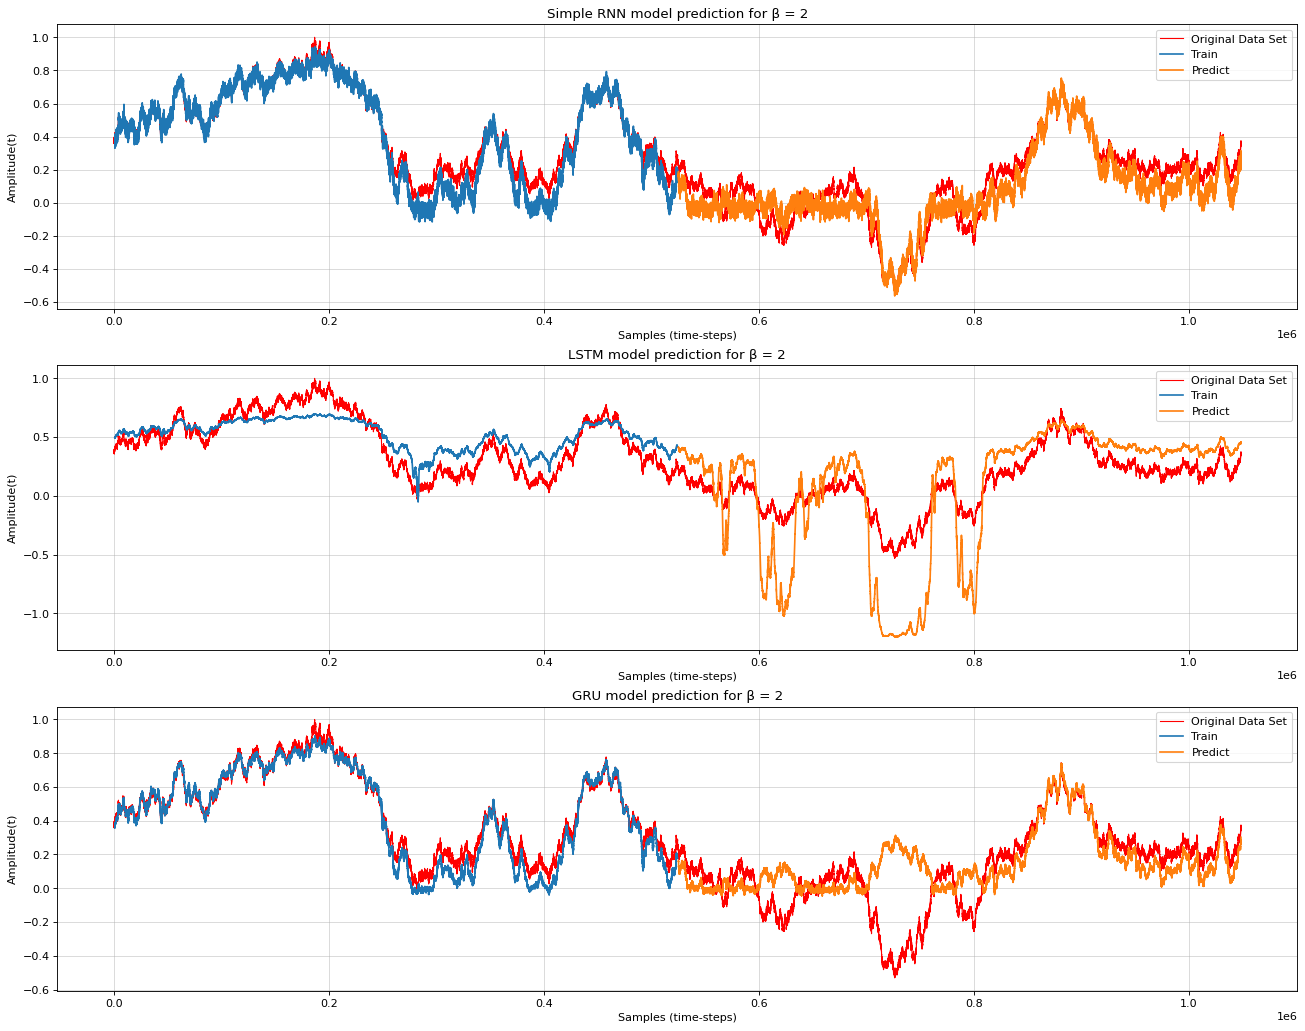

In [19]:
i=2
if   beta == '0.0': df_color = 'black'
elif beta == '1.0': df_color = 'magenta'
else                     : df_color = 'red'

grossura = 0.5 if beta== '0.0' else 1

plt.figure(figsize = (20,4*len(model)+4), dpi=80)
for i in range(len(model)):
  plt.subplot(len(model),1,(i+1))
  plt.plot(dataset,label="Original Data Set",color = df_color,linewidth=grossura)
  plt.plot(trainPredictPlot[i],label='Train',color='C0')
  plt.plot(testPredictPlot[i],label='Predict',color='C1')
  plt.title(str(model_name[i])+' model prediction for β = '+str(beta))
  plt.ylabel('Amplitude(t)')
  plt.xlabel('Samples (time-steps)')
  plt.legend()
  plt.grid(alpha=0.5)
plt.show()

## Auto Prediction 

Now we will create a function to automatica generate new data. The model will predeict a value and the will add this value in the incial vector to be predict and erase the incial point

```
x = [1,2,3,4]
y = model.predic(x) # y = 5
x.append(y)
x = x[1:] 
x = [2,3,4,5]
```

the we star again saving all values of `y`



In [20]:
def autoGen(data,output_size=10,n_features=1,model_type=model[0]): 
  lst_output = []                                      # Empty Vector   
  model = model_type                                   # Alocatin the Model
  #data = list(dataset[-(look_back+1):,:])             # Alocating data as a list ?                                       
  data = list(data)                                    #   "   "    
  for i in range(0,output_size):                       # Iniciating the loop for output_size stop point                  
    x_input=np.array(list(data)[1:])                   # Inputad data in a numpy format                       
    x_input = x_input.reshape(1, n_features,look_back) # Reshapping the vector [??????????]                                        
    yhat = model.predict(x_input, verbose=0)           # Predictin the next value for the model                                 
    lst_output.append(yhat[0][0])                      # Saving the predicted Values                   
    data.append(np.array([lst_output[-1]]))            # Alocating the last value of the predictd vector                              
    data = data[1:]                                    # redefining the data incial vector       
  return lst_output                                    # print the output value

In [21]:
dat = dataset[-(look_back+1):,:]
i = 0
predict = []
for i in range(len(model)):
    predict.append(autoGen(dat,2*look_back,model_type=model[i]))

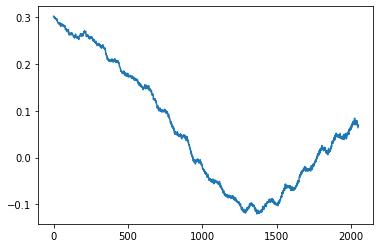

In [28]:
i=2
plt.plot(predict[i],label=model_name[i])

In [31]:
color

['C0', 'C1', 'C2']

<Figure size 432x288 with 0 Axes>

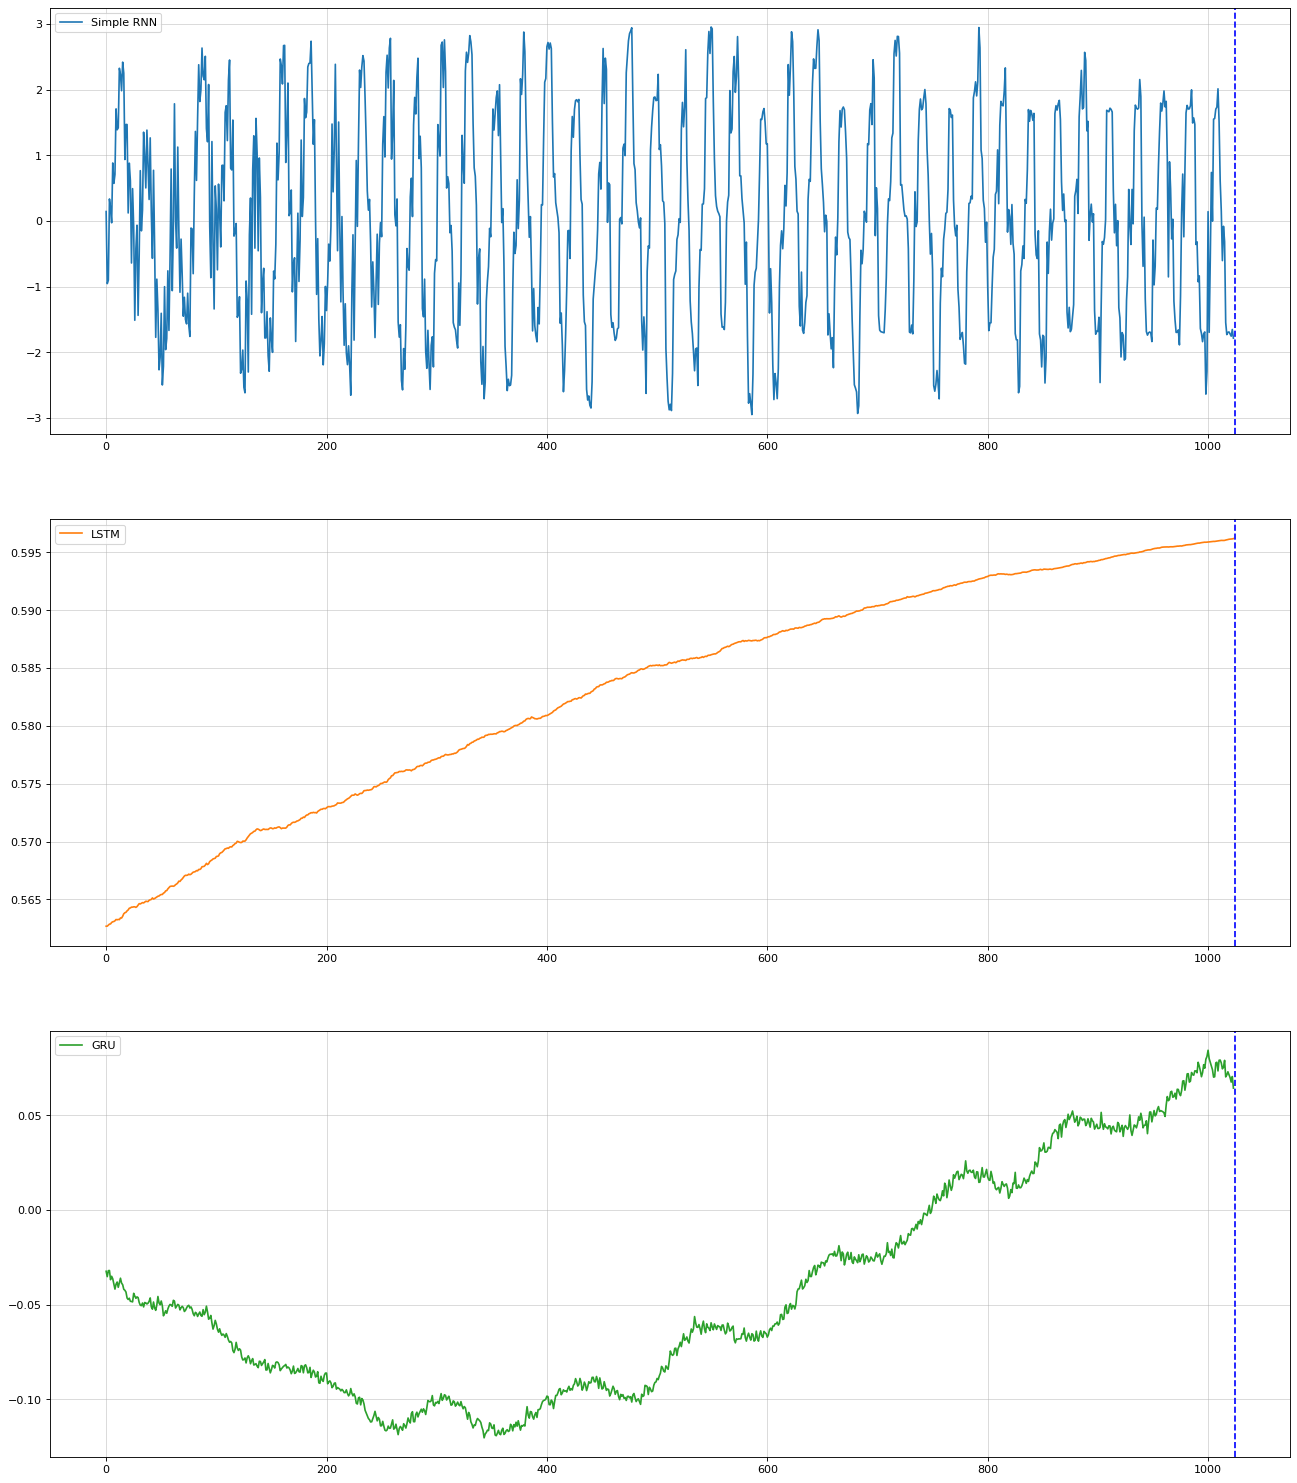

In [42]:
plt.suptitle('Predicted values')
plt.figure(figsize = (20,4*(len(model)+1)+8), dpi=80)
for i in range(len(model)):
  plt.subplot(len(model),1,i+1)
  plt.plot(predict[i],label=model_name[i],color=color[i])
  plt.axvline(x=look_back,linestyle='--',c='b')
  plt.legend()
  plt.grid(alpha=0.5)
plt.show()  

## SpecPlus

Generation of the Power Spectrum of a time series

In [23]:
def specplus(nomeArquivo,INICIO=10,FIM=6300, textoTituloPSD = r'Original Time Series - ',corPSD2 =  'navy'):
    #FIM = 2**int(np.log2(len(trainPredict[i]))-1)
    import matplotlib.pyplot as plt
    import matplotlib.mlab as mlab
    from scipy import stats, optimize
    import numpy as np
    import math
 
    #---------------------------------------------------------------------
    # Calcula o PSD da série temporal
    #---------------------------------------------------------------------

    def psd(data):
        """Calcula o PSD de uma série temporal."""
        # Define um intervalo para realizar o ajuste da reta
        # INICIO = 15
        # FIM = 6300
        # O vetor com o tempo é o tamanho do número de pontos
        N = len(data)#int(len(data)/2)
        tempo = np.arange(len(data))
        # Define a frequência de amostragem
        dt = (tempo[-1] - tempo[0] / (N - 1))
        fs = 1 / dt
        # Calcula o PSD utilizando o MLAB
        power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)
        # Calcula a porcentagem de pontos utilizados na reta de ajuste
        totalFrequencias = len(freqs)
        totalPSD = FIM - INICIO
        porcentagemPSD = int(100 * totalPSD / totalFrequencias)
        # Seleciona os dados dentro do intervalo de seleção
        xdata = freqs[INICIO:FIM]
        ydata = power[INICIO:FIM]
        # Simula o erro
        yerr = 0.2 * ydata
        # Define uma função para calcular a Lei de Potência
        powerlaw = lambda x, amp, index: amp * (x**index)
        # Converte os dados para o formato LOG
        logx = np.log10(xdata)
        logy = np.log10(ydata)
        # Define a função para realizar o ajuste
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err    
        logyerr = yerr / ydata
        # Calcula a reta de ajuste
        pinit = [1.0, -1.0]
        out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)    
        pfinal = out[0]
        covar = out[1]
        index = pfinal[1]
        amp = 10.0 ** pfinal[0]
        indexErr = np.sqrt(covar[0][0])
        ampErr = np.sqrt(covar[1][1]) * amp
        # Retorna os valores obtidos
        return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM

    def main():
        """Função com o código principal do programa."""
        #print("\nSpectral Analysis for time series...\n")
        # Desabilita as mensagens de erro do Numpy (warnings)
        old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
        # Carrega o arquivo de dados
        #nomeArquivo = 'serie1.txt'     

        pd.DataFrame(nomeArquivo[:2**int(np.log2(len(nomeArquivo)))]).to_csv("data.csv", index=False, header=False)
        #pd.DataFrame(model_data[0][:2**int(np.log2(len(model_data)))]).to_csv("model.csv", index=False, header=False)

        #csv_para_txt
        import csv
        with open("data.txt", "w") as my_output_file: 
            with open("data.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
            my_output_file.close()

        data = np.genfromtxt('data.txt',
                             delimiter = ',',
                             dtype = 'float32',
                             filling_values = 0)

        # Exibe os primeiro N valores do arquivo
        #N = 10
        #fig = plt.figure(figsize=(6,4), dpi=100)
        #fig.subplots_adjust(hspace = .4, wspace = .2)
        # Tamanho das fontes
        tamanhoFonteEixoX     = 16
        tamanhoFonteEixoY     = 20
        tamanhoFonteTitulo    = 16
        tamanhoFontePrincipal = 25
        # Título principal
        tituloPrincipal = 'Time Series Spectral Analysis'   
        #-----------------------------------------------------------------
        # Plotagem da série original
        #-----------------------------------------------------------------
        # Define as cores da plotagem
        #corSerieOriginal = cor# 'r'
        # Título dos eixos da série original
        textoEixoX = 'Time'
        textoEixoY = 'Amplitude'
        #textoTituloOriginal = titulo

        #-----------------------------------------------------------------
        # Cálculo e plotagem do PSD                                     --
        #-----------------------------------------------------------------
        # Calcula o PSD
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)
        # O valor do beta equivale ao index
        b = index
        # Define as cores da plotagem
        corPSD1 = 'k'
        #corPSD2 =  'orange' if modelo_nome == 'GRU' else 'green'
        #corPSD2 =  'navy'# if nomeArquivo == 'serie_time.txt' else 'orange' if modelo_nome == 'GRU' else 'green'
        # Título dos eixos do PSD
        textoPSDX = 'Frequency (Hz)'
        textoPSDY = 'PSD'
        #textoTituloPSD = r''+str(modelo_nome)+' - PSD Estimation β = '
        # Plotagem do PSD    
        #PSD = fig.add_subplot(2, 2, (1,4))    
        plt.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
        plt.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
        plt.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
        plt.axvline(freqs[FIM], color = corPSD2, linestyle = '--')    
        plt.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))    
        plt.xlabel(textoPSDX                                  )#, fontsize = tamanhoFonteEixoX)
        plt.ylabel(textoPSDY                                  )#, fontsize = tamanhoFonteEixoY)
        plt.title(textoTituloPSD + ' β = %.4f' %(b), loc = 'center')#, fontsize = tamanhoFonteTitulo)
        plt.yscale('log')
        plt.xscale('log')
        plt.grid() 
        #fig.set_size_inches(7, 4)
        #plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)    
        #plt.show()

    if __name__ == "__main__":
        main()
    #——————————————————————————————————————————

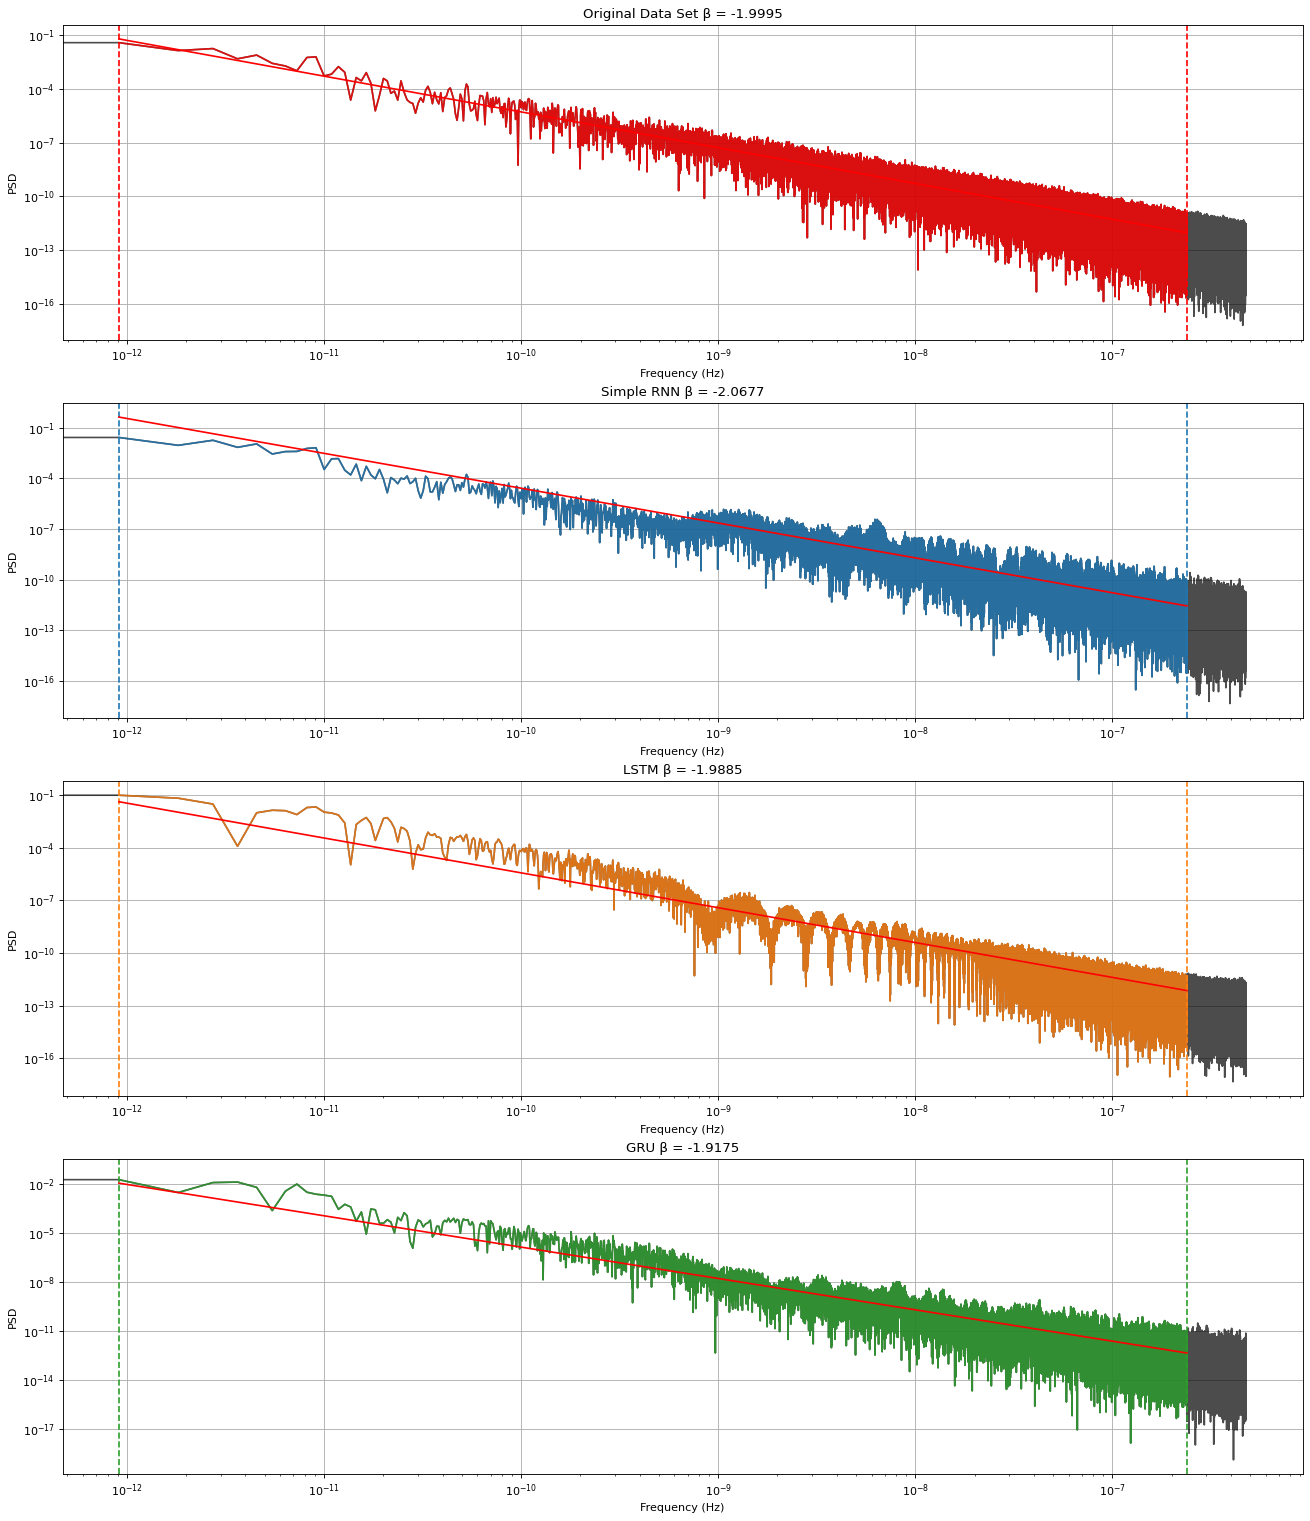

In [24]:
plt.figure(figsize = (20,4*(len(model)+1)+8), dpi=80)
plt.subplot(len(model)+1,1,1)
specplus(dataset,         #Dataframe
          1,              #Incial Value
          2**int(np.log2(len(dataset))-2), #Final Value
          'Original Data Set',   #Chat Tile
          'red')           #Color
for i in range(len(model)):
  plt.subplot(len(model)+1,1,i+2)
  specplus(model_data[i],  #Dataframe
           1,              #Incial Value
           2**int(np.log2(len(model_data[i]))-2), #Final Value
           model_name[i],   #Chat Tile
           color[i])        #Color
plt.show()

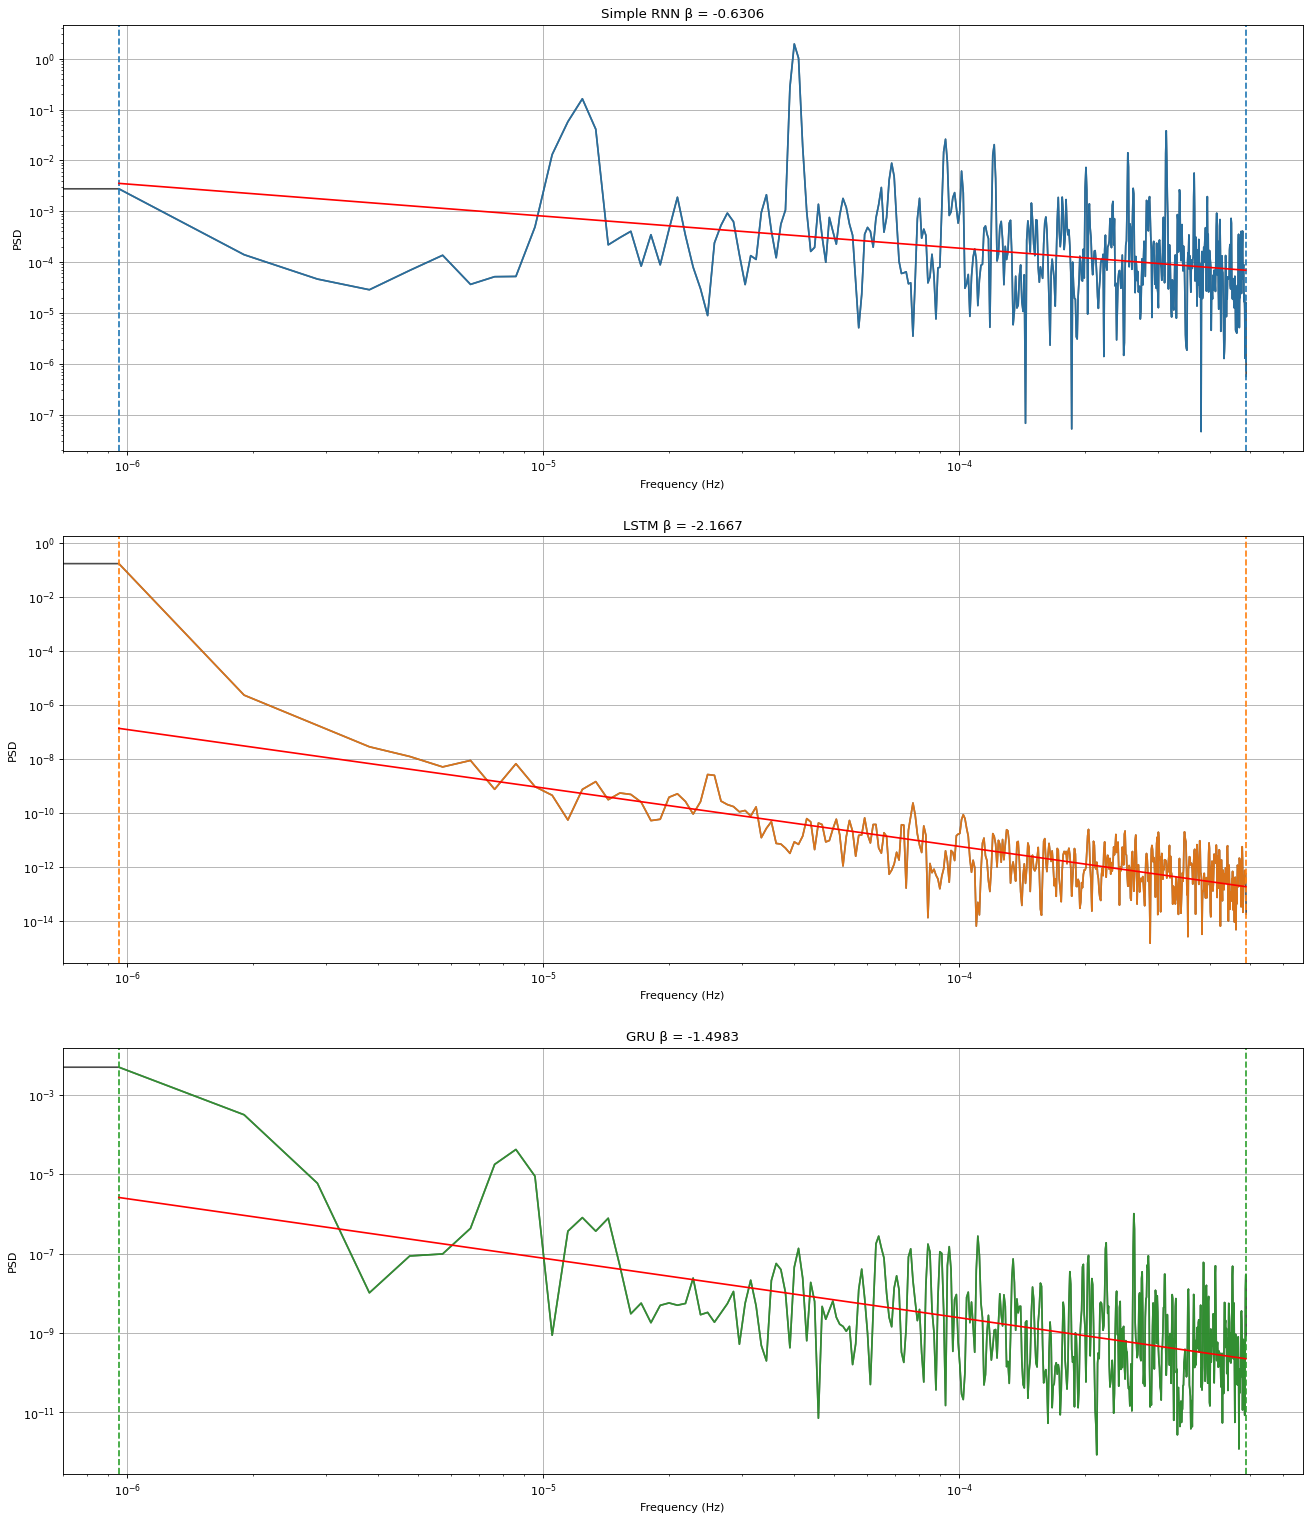

In [44]:
plt.figure(figsize = (20,4*(len(model)+1)+8), dpi=80)
for i in range(len(model)):
  plt.subplot(len(model),1,i+1)
  specplus(predict[i][look_back:],  #Dataframe
           1,              #Incial Value
           2**int(np.log2(len(predict[i][look_back:])-2)), #Final Value
           model_name[i],   #Chat Tile
           color[i])        #Color
plt.show()



In [25]:
#remove all
#!rm *

In [26]:
#Ziping Data for download📦
#!zip -r /content/drive/MyDrive/Kaggle/model_RNN.zip /content/model_RNN/

# References

https://www.tensorflow.org/guide/keras/save_and_serialize

https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

[Prediction and analysis of COVID-19 positive cases using deep learning models: A descriptive case study of India](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7298499/pdf/main.pdf)

[LSTM Models For Univariate Time Series Forecasting](https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)